In [1]:
from lmmNet import lmmNet

import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt

# 1. Training

Here we test the problem on the 2-D Cubic Harmonic Oscillator

$$ \begin{array}
\dot{x_1} & = & -0.1 x_1^3 + 2.0 x_2^3 \\
\dot{x_2} & = & -2.0 x_1^3 - 0.1 x_2^3 \\
\end{array} $$

with the initial conditions $x_1(0) = 2, x_2(0) = 0$.

In [2]:
def f(x,t):
    """
    Return the derivatives (RHS of the ODE)
    This is a linear system with the form f = A x
    Args:
    x -- a 2 x 1 vector of measurements
    """
    A = np.array([[-0.1, 2], [-2,-0.1]]) # 2 x 2

    return np.ravel(np.matmul(A,x.reshape(-1, 1)**3))

Now we are ready to create the training dataset by integrating the above system of equations to obtain the measurements. We also introduce a Gaussian noise to the dataset.

In [3]:
# create time points
time_points = np.arange(0, 25, 0.01)

# specify initial conditions
x0 = np.array([2,0])

simulated_x = odeint(f, x0, time_points)

In [4]:
# create training data

noise = 0.00 #strength of the noise

skip = 1
dt = time_points[skip] - time_points[0]
X_train = simulated_x[0::skip,:]
X_train = X_train + noise * X_train.std(0) * np.random.randn(X_train.shape[0], X_train.shape[1])

X_train = np.reshape(X_train, (1,X_train.shape[0],X_train.shape[1]))

This notebook was developed with LMMNet v1.1. From preliminary experiments, it seems that 10,000 epochs are sufficient to get a loss that more or less converges.

In [5]:
X_train.shape

(1, 2500, 2)

In [6]:
# training
# right now the layers are hardcoded.

M = 1
scheme = 'AM'
model = lmmNet(dt, X_train, M, scheme)

N_Iter = 10000
model.train(N_Iter)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0, Loss: 6.455e-04, Time: 0.18
Epoch: 100, Loss: 2.816e-04, Time: 7.27
Epoch: 200, Loss: 2.808e-04, Time: 13.86
Epoch: 300, Loss: 2.801e-04, Time: 20.47
Epoch: 400, Loss: 2.795e-04, Time: 27.03
Epoch: 500, Loss: 2.789e-04, Time: 33.49
Epoch: 600, Loss: 2.783e-04, Time: 39.95
Epoch: 700, Loss: 2.778e-04, Time: 46.96
Epoch: 800, Loss: 2.772e-04, Time: 53.60
Epoch: 900, Loss: 2.766e-04, Time: 60.03
Epoch: 1000, Loss: 2.757e-04, Time: 66.57
Epoch: 1100, Loss: 2.743e-04, Time: 73.84
Epoch: 1200, Loss:

In [7]:
def ml_f(x):
    """
    Define the derivatives (RHS of the ODE) learned by ML
    I think this is the best implementation (more robust than flatten())
    """
    return np.ravel(model.predict(x.reshape(1,-1)))
    
predicted_traj = odeint(lambda x, t: ml_f(x), x0, time_points)

In [8]:
with open('test_pred.npy', 'wb') as file:
    np.save(file, predicted_traj)

predicted_traj

array([[ 2.        ,  0.        ],
       [ 1.99184461, -0.15868707],
       [ 1.98370189, -0.31566392],
       ...,
       [-0.44934228, -0.26318173],
       [-0.44957851, -0.26124573],
       [-0.44980689, -0.25930684]])

# 2. Validation

You may need to terminate kernel to run the codes below. There are OpenMP issues with TensorFlow 2.0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

time_points = np.arange(0,25,0.01)
with open('test_pred.npy', 'rb') as file:
    test_pred = np.load(file)

def f(x,t):
    """
    Return the derivatives (RHS of the ODE)
    This is a linear system with the form f = A x
    Args:
    x -- a 2 x 1 vector of measurements
    """
    A = np.array([[-0.1, 2], [-2,-0.1]]) # 2 x 2

    return np.ravel(np.matmul(A,x.reshape(-1, 1)**3))

# create time points
time_points = np.arange(0,25,0.01)

# specify initial conditions
x0 = np.array([2,0])

simulated_x = odeint(f, x0, time_points)

Text(0.5, 1.0, 'Trajectories of 2D Cubic Harmonic Oscillator')

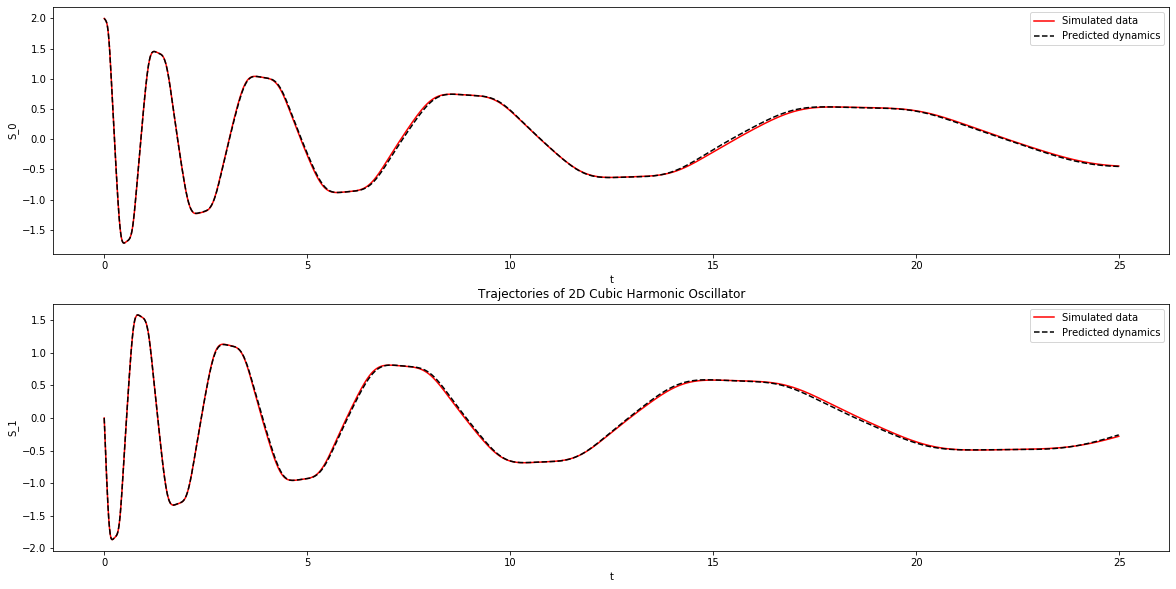

In [3]:

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, simulated_x[:, species], 'r-', label='Simulated data')
    plt.plot(time_points, test_pred[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Cubic Harmonic Oscillator')

Text(0.5, 1.0, 'Phase plane of 2D Cubic Harmonic Oscillator')

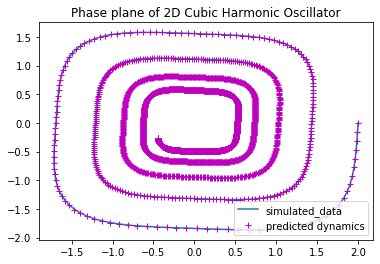

In [4]:
# Phase plane

plt.plot(simulated_x[:,0], simulated_x[:,1], label='simulated_data')
plt.legend()
plt.plot(test_pred[:,0], test_pred[:,1], 'm+', label='predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Cubic Harmonic Oscillator')